Copying files: 15016 files [03:30, 71.24 files/s]


Found 8996 images belonging to 36 classes.
Found 2989 images belonging to 36 classes.
Found 3031 images belonging to 36 classes.
training


Epoch 1/50


282/282 [==============================] - 334s 1s/step - loss: 1.2396 - accuracy: 0.6636 - val_loss: 2.4644 - val_accuracy: 0.2389 - lr: 5.0000e-04
Epoch 2/50
282/282 [==============================] - 192s 679ms/step - loss: 0.4651 - accuracy: 0.8727 - val_loss: 0.3277 - val_accuracy: 0.9050 - lr: 5.0000e-04
Epoch 3/50
282/282 [==============================] - 199s 707ms/step - loss: 0.3068 - accuracy: 0.9160 - val_loss: 0.2085 - val_accuracy: 0.9324 - lr: 5.0000e-04
Epoch 4/50
282/282 [==============================] - 287s 1s/step - loss: 0.2328 - accuracy: 0.9398 - val_loss: 0.0932 - val_accuracy: 0.9689 - lr: 5.0000e-04
Epoch 5/50
282/282 [==============================] - 187s 664ms/step - loss: 0.1936 - accuracy: 0.9479 - val_loss: 0.0448 - val_accuracy: 0.9896 - lr: 5.0000e-04
Epoch 6/50
282/282 [=============================

c:\Softwares\ANNA\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Training samples (with augmentation):


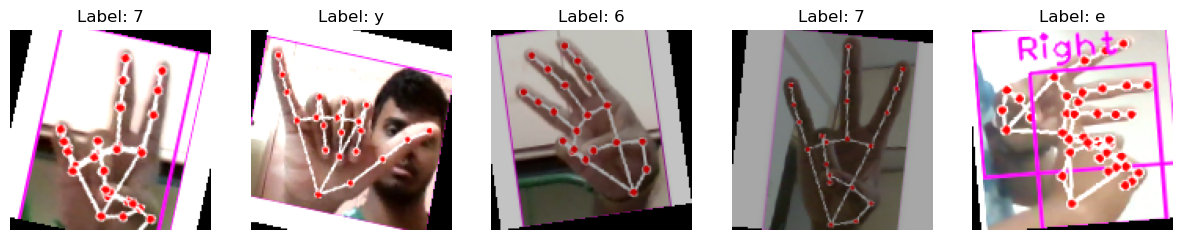


Validation samples (no augmentation):


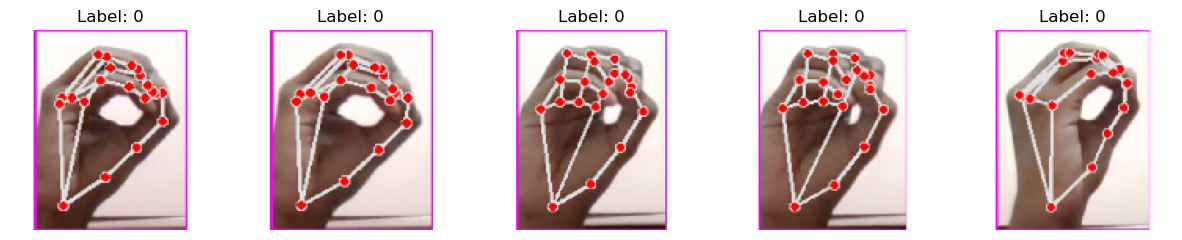

In [ ]:
# Import libraries
import numpy as np
import splitfolders
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Step 1: Dataset Preprocessing and Splitting (No changes needed here unless your folder structure is different)
# --------------------------------------------
input_folder = "Final_Sign_Dataset"
output_folder = "preprocessed_alphaDigi_dataset"
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.6, 0.2, 0.2),
    group_prefix=None,
    move=False
)

# Step 2: Create Data Generators with Preprocessing
# ------------------------------------------------

# Training generator with more aggressive augmentation (within reason for sign language)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,  # Add horizontal shift
    height_shift_range=0.05, # Add vertical shift
    zoom_range=0.05,
    shear_range=0.03,        # Add shear
    horizontal_flip=False,
    brightness_range=[0.6, 1.4], # More variation in brightness
    fill_mode='constant',
    cval=0                      # Fill with black (often better than white for CNNs)
)

# Validation and Test generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Common parameters
target_size = (128, 128)
color_mode = 'rgb'  # Experiment with RGB - might capture more subtle features
batch_size = 32
class_mode = 'categorical'

# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_folder, 'train'),
    target_size=target_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'val'),
    target_size=target_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False # No need to shuffle validation data
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'test'),
    target_size=target_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False # Important for accurate evaluation
)

# Step 3: Improved Model Building
# ----------------------

print("training")
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'), 
    BatchNormalization(),
    Dropout(0.5),

    Dense(train_generator.num_classes, activation='softmax')
])

# Use a smaller learning rate initially and add ReduceLROnPlateau
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 4: Training with Enhanced Callbacks
# ------------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1) # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1) # Reduce LR if val_loss plateaus

history = model.fit(
    train_generator,
    epochs=50, # Increased epochs - early stopping will handle overtraining
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# Step 5: Final Evaluation
# ------------------------
print("\nTest Set Evaluation:")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2%}")

# Save the model
model.save('sign_language_alphaDigi_model.h5')

# Optional: Visualize Preprocessing
# ---------------------------------
def visualize_augmentations(generator, num_images=5):
    x, y = generator.next()
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x[i].squeeze())
        plt.title(f"Label: {list(generator.class_indices.keys())[np.argmax(y[i])]}")
        plt.axis('off')
    plt.show()

print("\nTraining samples (with augmentation):")
visualize_augmentations(train_generator)

print("\nValidation samples (no augmentation):")
visualize_augmentations(val_generator)